# Data Exploration - Oticon Audio Explorers

In [1]:
from pathlib2 import Path
import os

from collections import Counter

import numpy as np
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

from tqdm.notebook import trange, tqdm

In [2]:
# set seed
np.random.seed(42)

# plot style
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 3
sns.set(font_scale=1.5)

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

### Load data

In [3]:
DATA_DIR = Path('../data')

# Load npy-files
Xtrainval   = np.load(DATA_DIR / 'raw/npy/training.npy')
ttrainval   = np.load(DATA_DIR / 'raw/npy/training_labels.npy')
Xtest       = np.load(DATA_DIR / 'raw/npy/test.npy')

# Load matlab files
Xtrain_mat  = loadmat(DATA_DIR / 'raw/mat/training.mat', squeeze_me=True)
ttrain_mat  = loadmat(DATA_DIR / 'raw/mat/training_labels.mat', squeeze_me=True)
Xtest_mat   = loadmat(DATA_DIR / 'raw/mat/test.mat', squeeze_me=True)

# Ensure no data difference
assert np.all(Xtrain_mat['data'] == Xtrainval)
assert np.all(ttrain_mat['data'] == ttrainval)
assert np.all(Xtest_mat['data'] == Xtest)

# Clean up
del Xtrain_mat
del ttrain_mat
del Xtest_mat

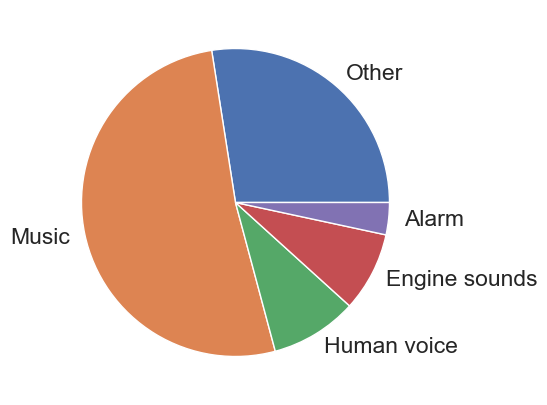

In [7]:
idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}
label_dist = dict(sorted(Counter(ttrainval).items(), key=lambda x: -x[1]))

label_counts = {idx2label[k]: v for k, v in label_dist.items()}
label_counts = {idx2label[i]: label_counts[idx2label[i]] for i in range(5)}

# Plot pie chart
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=label_counts.values(), labels=label_counts.keys())
plt.show()

#### Split dataset

In [8]:
np.random.seed(0)

# Get indexes
train_idxs  = np.random.choice(np.arange(Xtrainval.__len__()), size=int(Xtrainval.__len__() * 0.8), replace=False)
val_idxs    = np.setdiff1d(np.arange(Xtrainval.__len__()), train_idxs)

assert Xtrainval.__len__() == train_idxs.__len__() + val_idxs.__len__()

# Split training set
Xtrain_orig, Xval_orig = Xtrainval[train_idxs, :, :], Xtrainval[val_idxs, :, :]
ttrain_orig, tval_orig = ttrainval[train_idxs], ttrainval[val_idxs]

In [9]:
print(f"Xtrain: {Xtrain_orig.shape}")
print(f"ttrain: {ttrain_orig.shape}")

print(f"\nXval: {Xval_orig.shape}")
print(f"tval: {tval_orig.shape}")

print(f"\nXtest: {Xtest.shape}")

print(f"\nttrain labels in --> {np.unique(ttrain_orig)}")

print(f"\nXtrain (min, max): {Xtrain_orig.min(), Xtrain_orig.max()}")
print(f"Xtest (min, max): {Xtest.min(), Xtest.max()}")

Xtrain: (42312, 32, 96)
ttrain: (42312,)

Xval: (10578, 32, 96)
tval: (10578,)

Xtest: (5347, 32, 96)

ttrain labels in --> [0 1 2 3 4]

Xtrain (min, max): (-80.0, 7.6293945e-06)
Xtest (min, max): (-80.0, 7.6293945e-06)


### Summary

In [10]:
N_train     = len(Xtrain_orig)
N_val       = len(Xval_orig)
N_test      = len(Xtest)
num_classes = len(np.unique(ttrain_orig))

idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}
label2idx   = {v: k for k, v in idx2label.items()}

### ChatGPT background
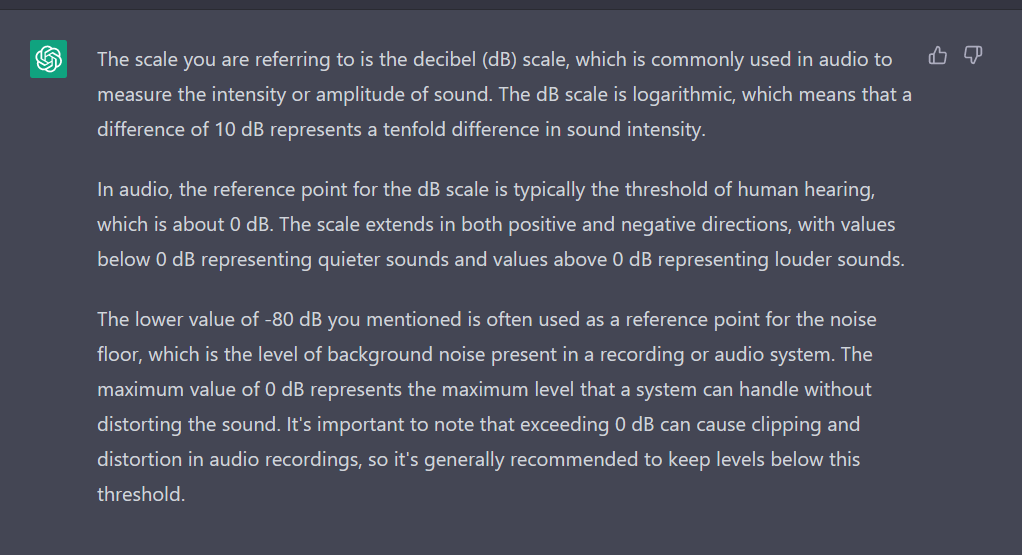

### Visualize label distribution


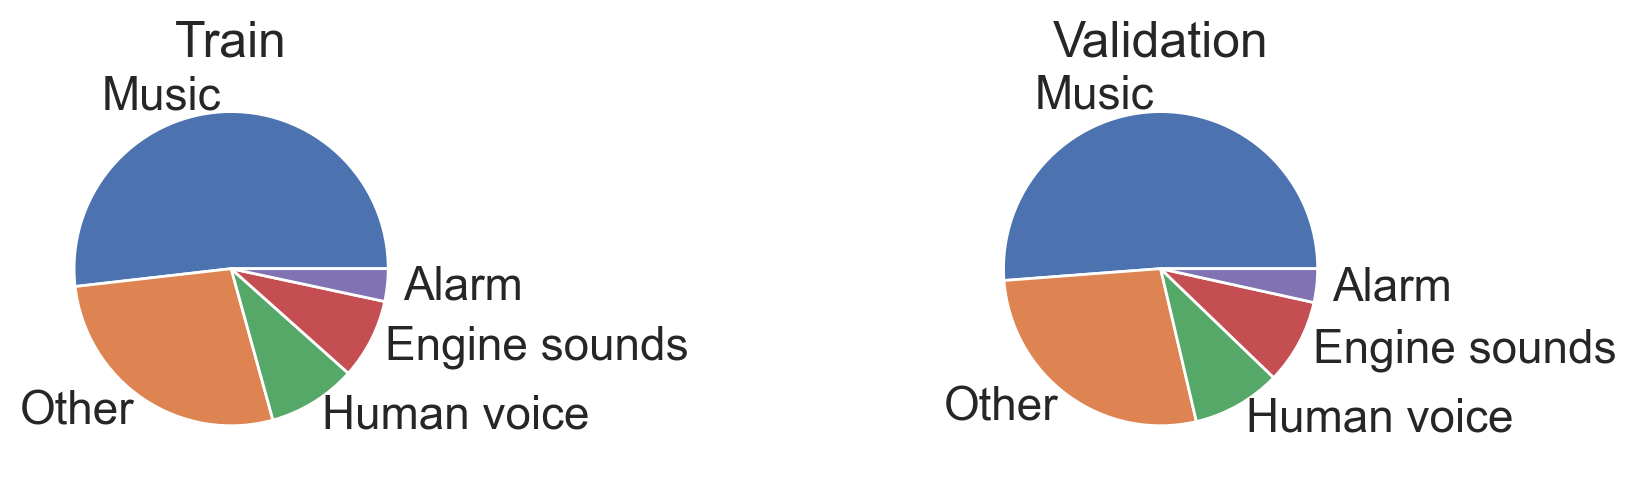

In [11]:
def visualize_label_distribution(ttrain, tval, plot = True):
    
    idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}
    label2idx   = {v: k for k, v in idx2label.items()}
    num_classes = len(np.unique(ttrain))
    
    N_train, N_val = len(ttrain), len(tval)
    
    label_dist = {'train': dict(sorted(Counter(ttrain).items(), key=lambda x: -x[1])), 'val': dict(sorted(Counter(tval).items(), key=lambda x: -x[1]))}

    label_counts = {dtype: {idx2label[k]: v for k, v in dict_.items()} for dtype, dict_ in label_dist.items()}
    label_freqs = {dtype: {idx2label[k]: v / (N_train if dtype == 'train' else N_val) for k, v in dict_.items()} for dtype, dict_ in label_dist.items()}

    if plot:
        # Plot pie chart
        fig = plt.figure(figsize=(10, 5), dpi=200)
        ax1 = plt.subplot2grid((2,2),(0,0))
        plt.pie(x=label_counts['train'].values(), labels=label_counts['train'].keys())
        plt.title('Train')

        ax1 = plt.subplot2grid((2,2), (0, 1))
        plt.pie(x=label_counts['val'].values(), labels=label_counts['val'].keys())
        plt.title('Validation')

        plt.tight_layout()
        plt.show()

    return label_counts, label_freqs

label_counts, label_freqs = visualize_label_distribution(ttrain_orig, tval_orig)


### Data balancing


In [12]:
def downsample(Xtrain_orig, ttrain_orig):
    
    label_counts, label_freqs = visualize_label_distribution(ttrain_orig, ttrain_orig, plot = False)

    # Naive downsampling to minority class size
    target_size = min(label_counts['train'].values())

    Xtrain_downsampled, ttrain_downsampled = [], []
    num_classes = len(np.unique(ttrain_orig))
    for i in range(num_classes):
        Xtrain_class    = Xtrain_orig[ttrain_orig == i]
        ttrain_class    = ttrain_orig[ttrain_orig == i]
        N_class         = Xtrain_class.__len__()

        # Randomly draw as many points as in minority class 
        keep_idxs   = np.random.choice(np.arange(N_class), size=target_size, replace=False)

        # Downsampled class data
        Xtrain_     = Xtrain_class[keep_idxs, :]
        ttrain_     = ttrain_class[keep_idxs]

        # Append class-selected data points
        Xtrain_downsampled.append(Xtrain_)
        ttrain_downsampled.append(ttrain_)

    # Concatenate
    Xtrain_downsampled = np.vstack(Xtrain_downsampled)
    ttrain_downsampled = np.concatenate(ttrain_downsampled)
    
    return Xtrain_downsampled, ttrain_downsampled


Xtrain_downsampled, ttrain_downsampled = downsample(Xtrain_orig, ttrain_orig)

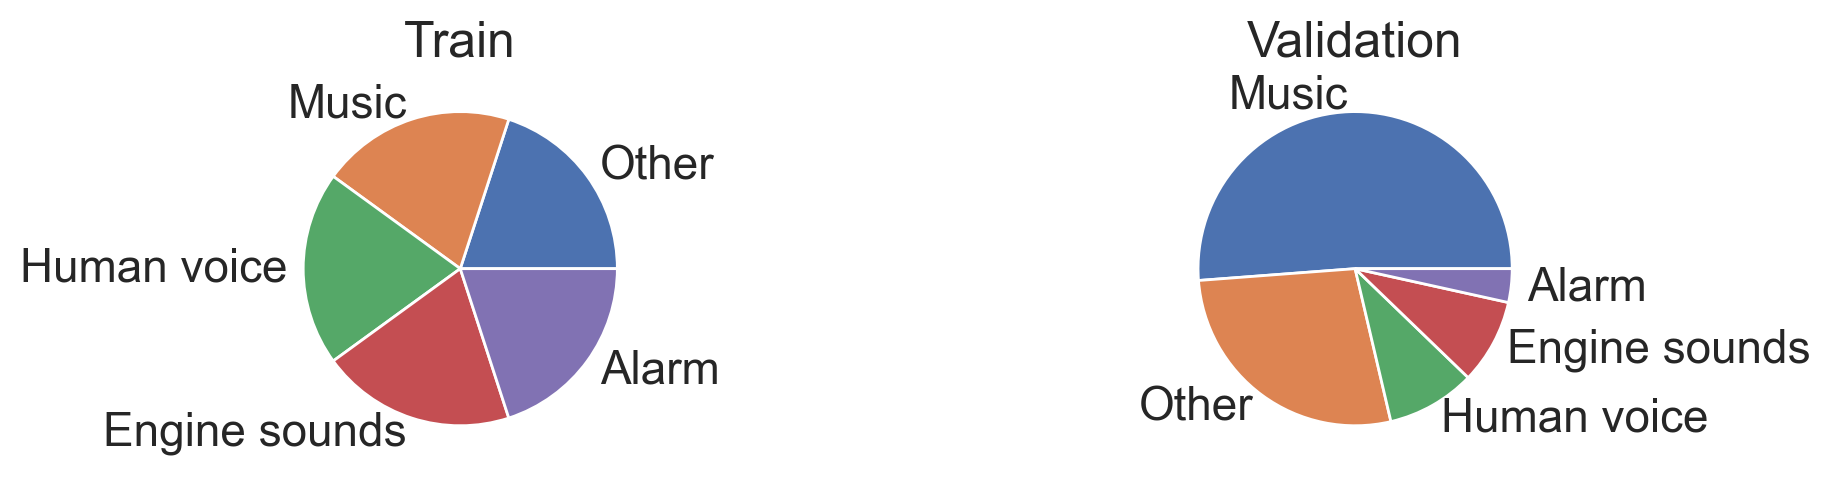

In [13]:
temp, _ = visualize_label_distribution(ttrain_downsampled, tval_orig)

### Visualize `Xtrain` and `Xtest`

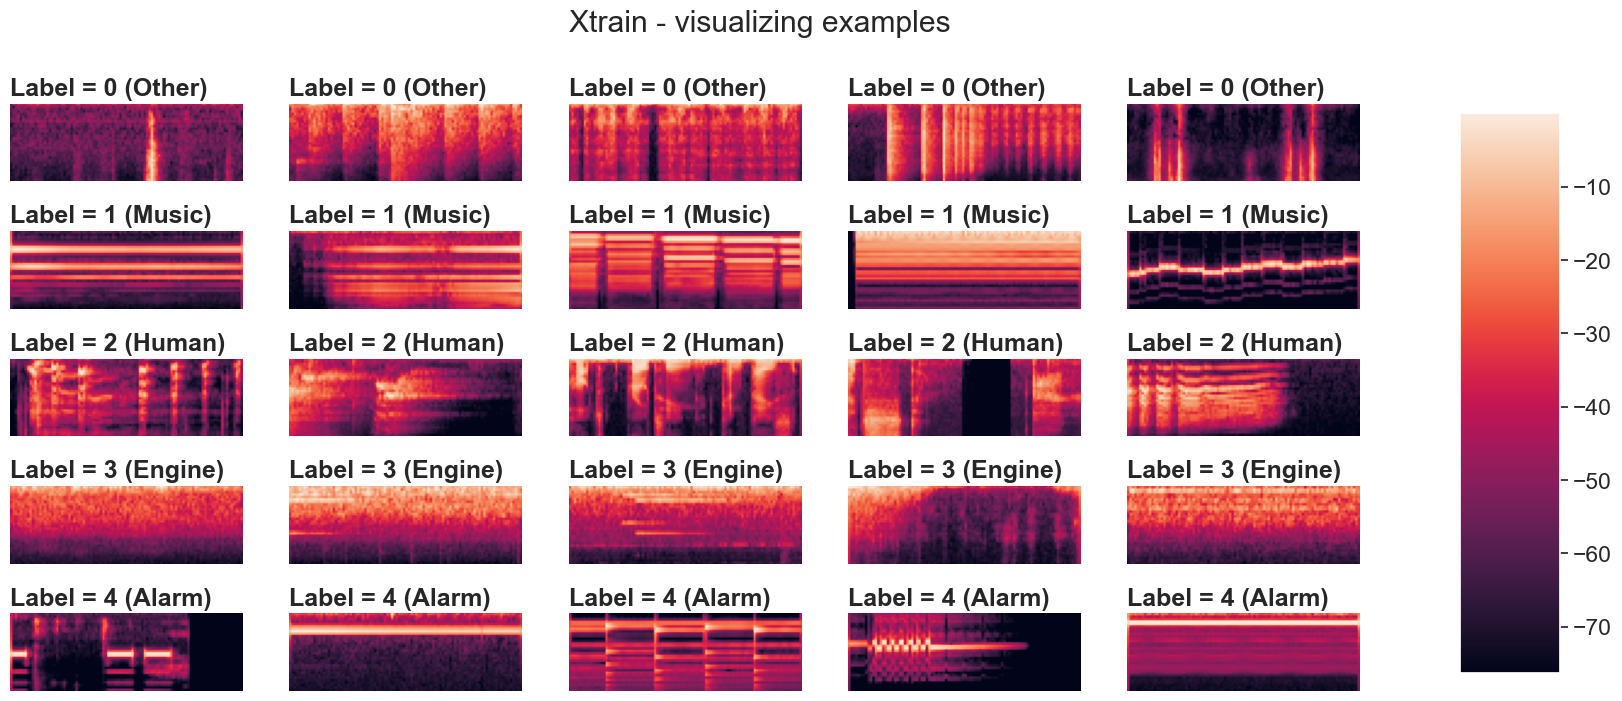

In [14]:
nrows, ncols = 5, 5

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 8))
for i in range(nrows):
    for j in range(ncols):

        # Select class
        Xtrain_class = Xtrain_orig[ttrain_orig == i]
        ttrain_class = ttrain_orig[ttrain_orig == i]
        # Select data point
        idx = np.random.choice(len(Xtrain_class))
        # Show spectrogram
        im = axs[i, j].imshow(Xtrain_class[idx])
        axs[i, j].axis('off')
        # Add label to title
        axs[i, j].set_title(f"Label = {ttrain_class[idx]} ({idx2label[ttrain_class[idx]].split()[0]})", loc='left', weight='bold')

# Add colorbar for dB scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Xtrain - visualizing examples')
plt.show()

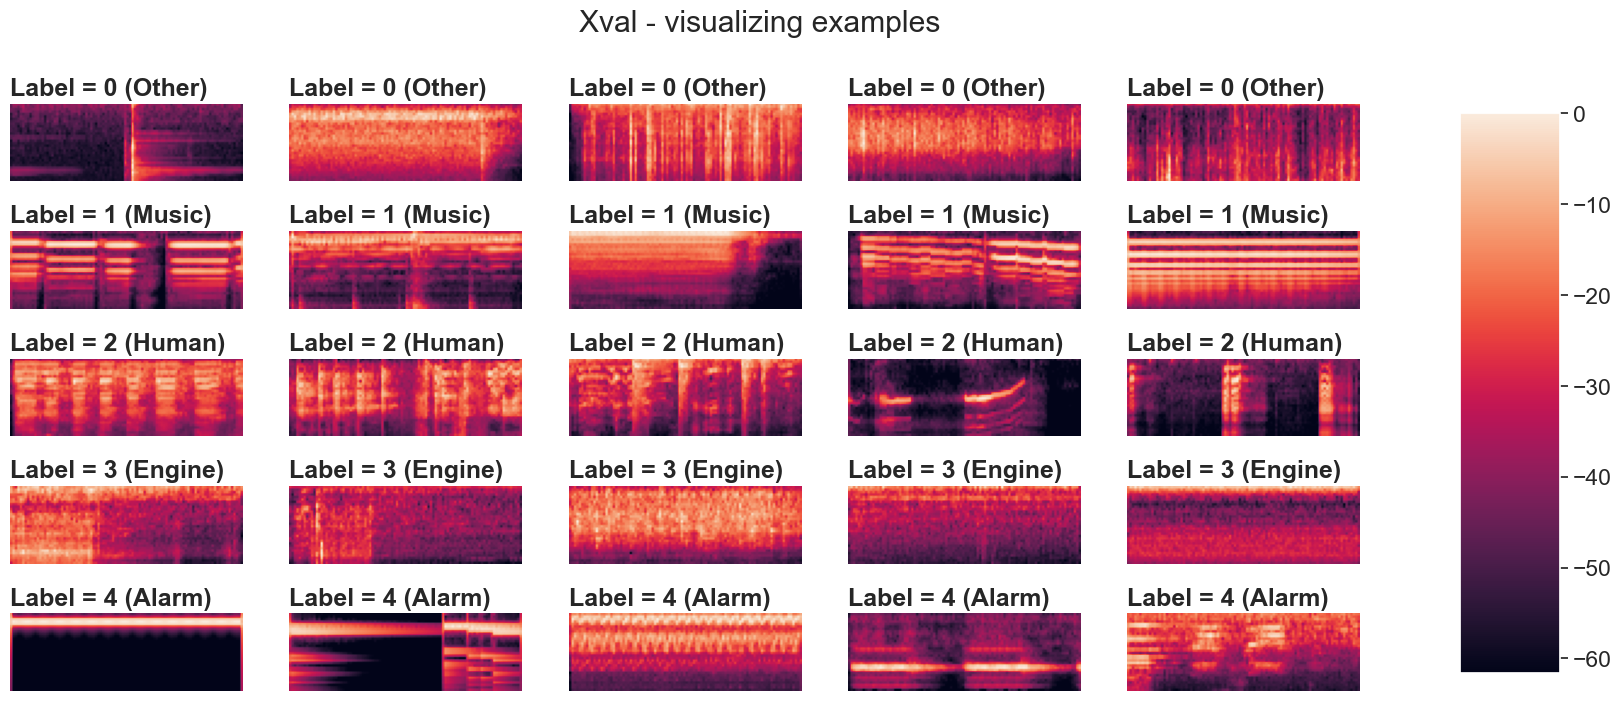

In [15]:
nrows, ncols = 5, 5

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 8))
for i in range(nrows):
    for j in range(ncols):

        # Select class
        Xval_class = Xval_orig[tval_orig == i]
        tval_class = tval_orig[tval_orig == i]
        # Select data point
        idx = np.random.choice(len(Xval_class))
        # Show spectrogram
        im = axs[i, j].imshow(Xval_class[idx])
        axs[i, j].axis('off')
        # Add label to title
        axs[i, j].set_title(f"Label = {tval_class[idx]} ({idx2label[tval_class[idx]].split()[0]})", loc='left', weight='bold')

# Add colorbar for dB scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Xval - visualizing examples')
plt.show()

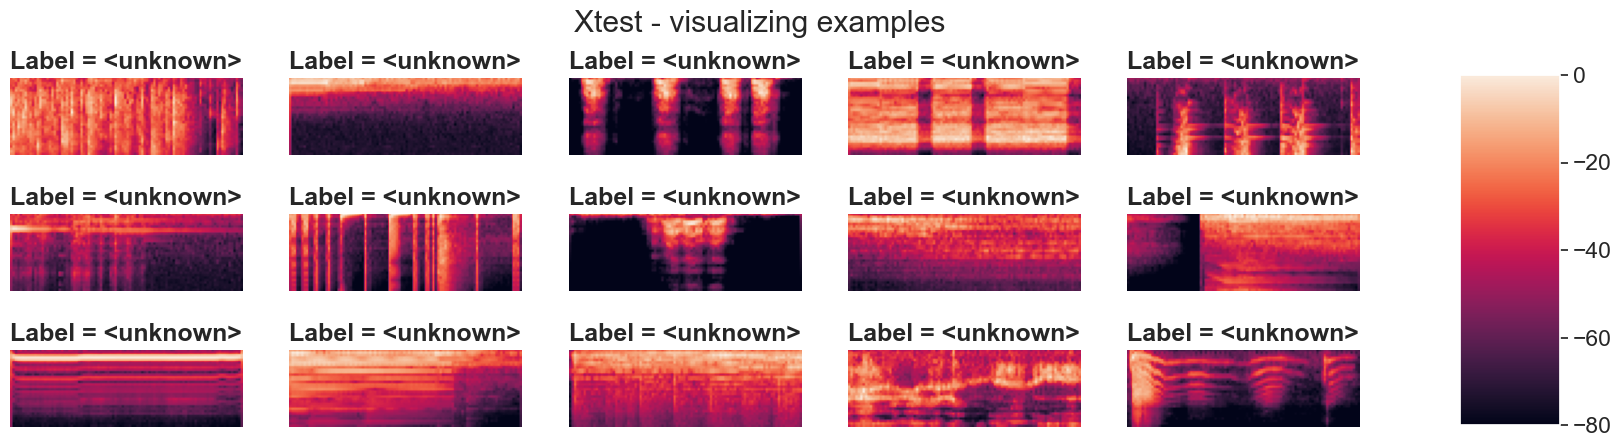

In [16]:
nrows, ncols = 3, 5

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 5), squeeze=False)
for i in range(nrows):
    for j in range(ncols):

        # Select data point
        idx = np.random.choice(len(Xtest))
        # Show spectrogram
        im = axs[i, j].imshow(Xtest[idx])
        axs[i, j].axis('off')
        # Add label to title
        axs[i, j].set_title(f"Label = <unknown>", loc='left', weight='bold')

# Add colorbar for dB scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Xtest - visualizing examples')
plt.show()

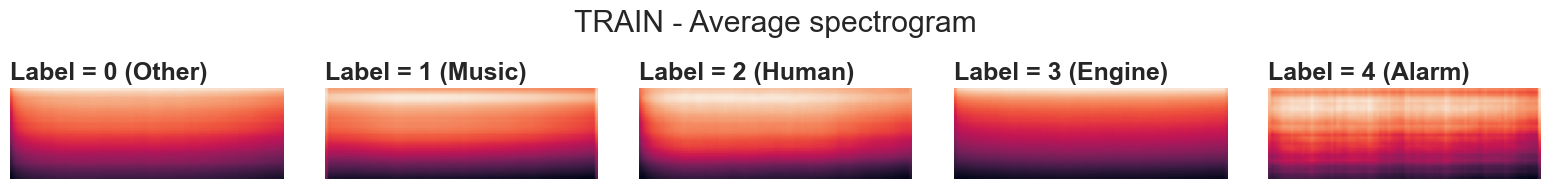

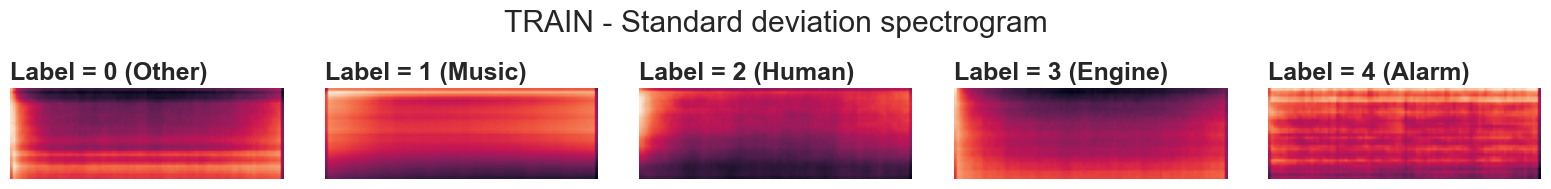

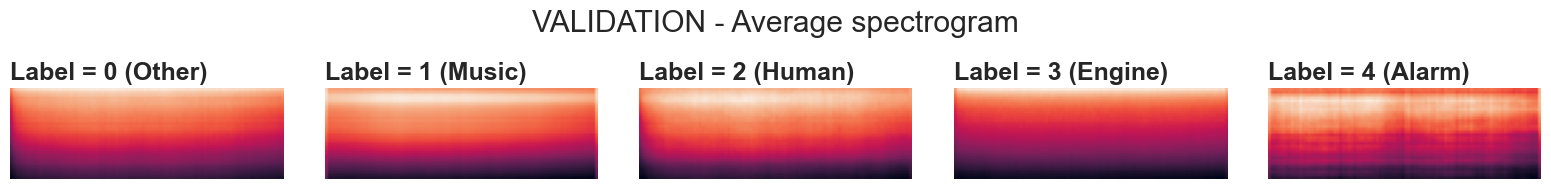

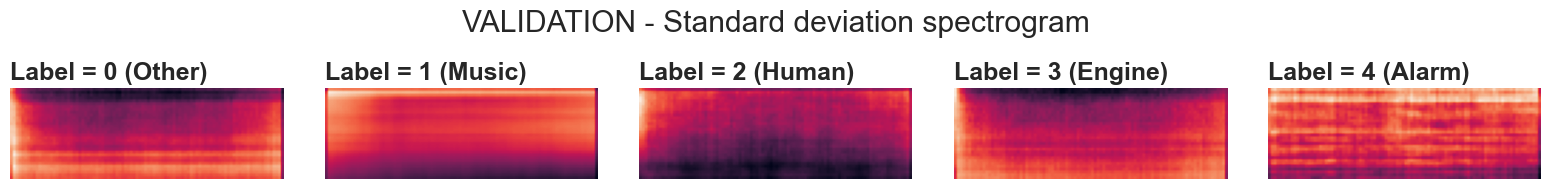

In [17]:
for dtype, X, t in [('train', Xtrain_orig, ttrain_orig), ('validation', Xval_orig, tval_orig)]:

    avg_spectrogram = [X[t == i].mean(axis=0) for i in range(num_classes)]
    std_spectrogram = [X[t == i].std(axis=0) for i in range(num_classes)]

    fig, axs = plt.subplots(1, num_classes, sharex=True, sharey=True, figsize=(16, 2))
    for i in range(num_classes): 
        axs[i].imshow(avg_spectrogram[i])
        axs[i].axis('off')
        axs[i].set_title(f"Label = {i} ({idx2label[i].split()[0]})", loc='left', weight='bold')

    fig.suptitle(f'{dtype.upper()} - Average spectrogram')
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, num_classes, sharex=True, sharey=True, figsize=(16, 2))
    for i in range(num_classes): 
        axs[i].imshow(std_spectrogram[i])
        axs[i].axis('off')
        axs[i].set_title(f"Label = {i} ({idx2label[i].split()[0]})", loc='left', weight='bold')

    fig.suptitle(f'{dtype.upper()} - Standard deviation spectrogram')
    plt.tight_layout()
    plt.show()

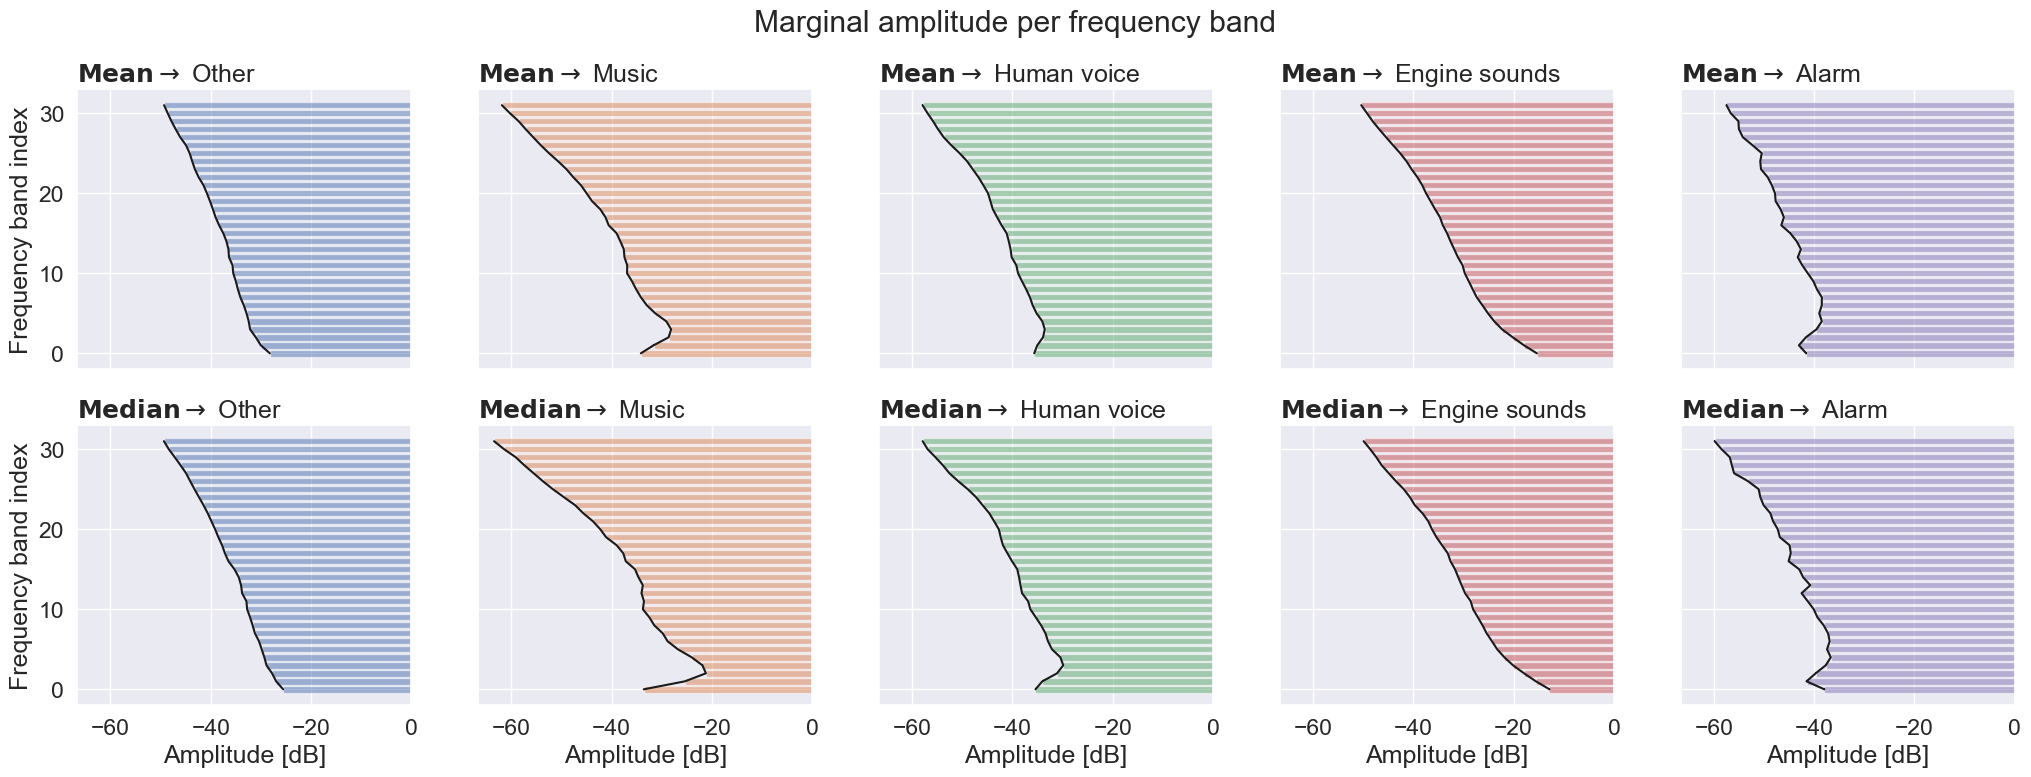

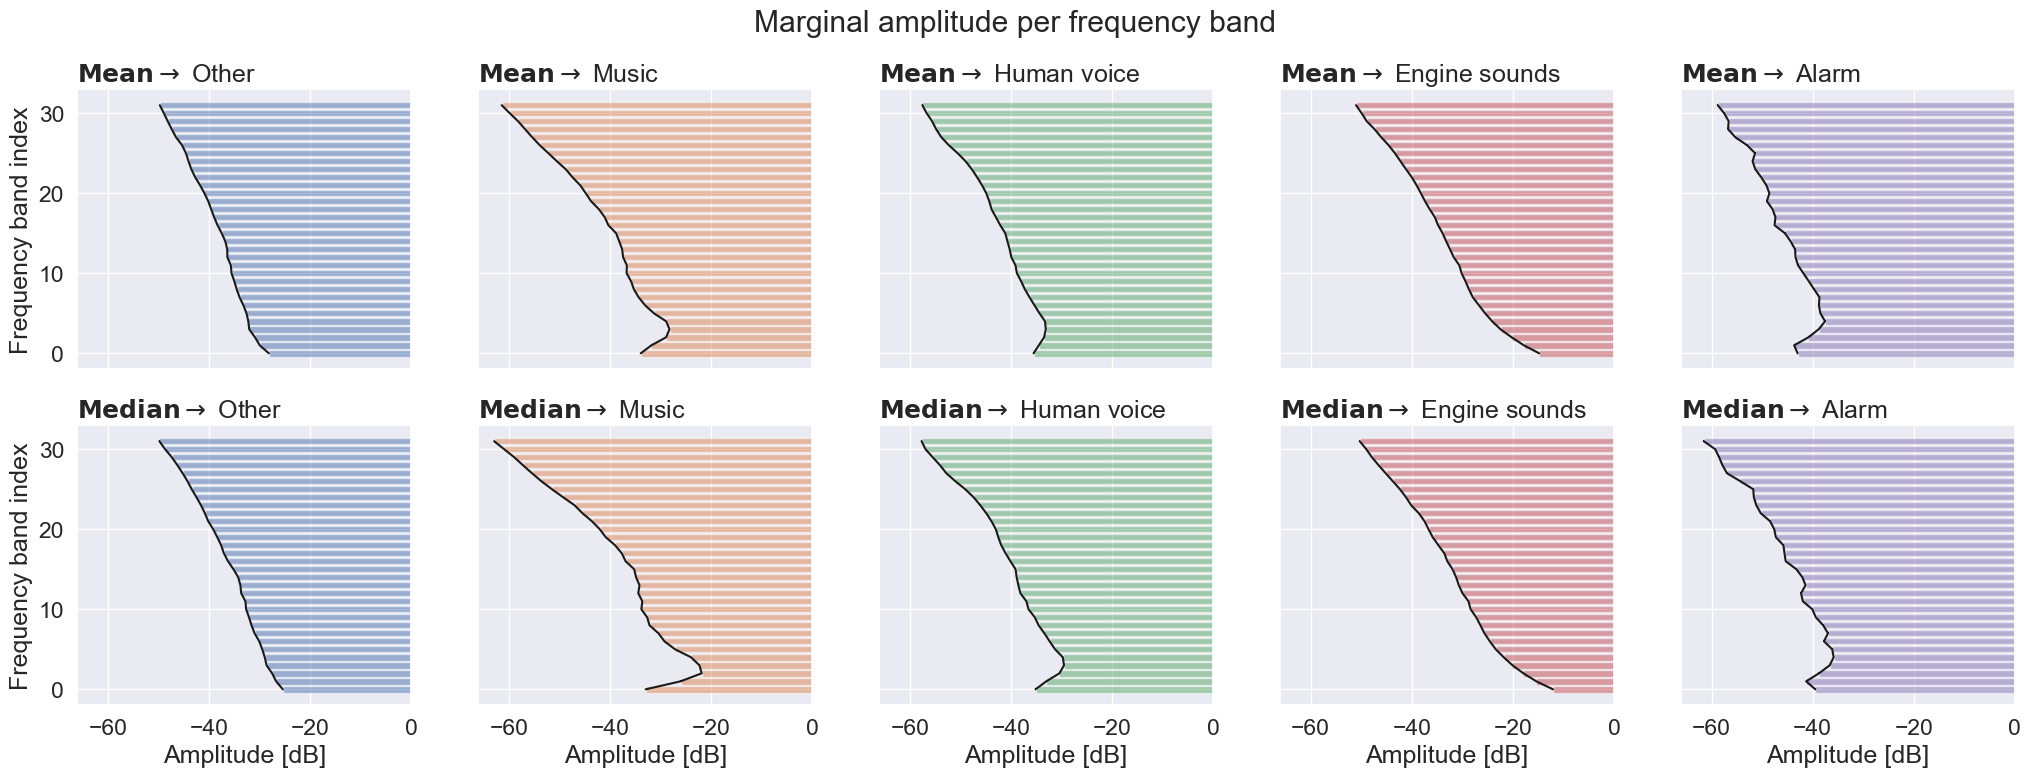

In [20]:
def plot_marginal_frequency(X, t):
    fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(25, 8))

    for i in range(num_classes):
        # Stack all spectrograms into 1
        Xtrain_class_h = np.hstack(X[t == i])

        # Plot marginal mean frequency per frequency band
        axs[0, i].barh(np.arange(32), np.mean(Xtrain_class_h, axis=1), alpha=0.5, color=colors[i])
        axs[0, i].errorbar(np.mean(Xtrain_class_h, axis=1), np.arange(32), xerr=np.std(Xtrain_class_h, axis=1) / np.sqrt(Xtrain_class_h.shape[1]), color='k')
        axs[0, i].set_title("$\mathbf{Mean} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

        # Plot marginal median frequency per frequency band
        axs[1, i].barh(np.arange(32), np.median(Xtrain_class_h, axis=1), alpha=0.5, color=colors[i])
        axs[1, i].errorbar(np.median(Xtrain_class_h, axis=1), np.arange(32), xerr=np.std(Xtrain_class_h, axis=1) / np.sqrt(Xtrain_class_h.shape[1]), color='k')
        axs[1, i].set_title("$\mathbf{Median} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

        axs[1, i].set_xlabel('Amplitude [dB]')

    axs[0, 0].set_ylabel('Frequency band index')
    axs[1, 0].set_ylabel('Frequency band index')

    fig.suptitle("Marginal amplitude per frequency band")
    plt.show()

plot_marginal_frequency(Xtrain_orig, ttrain_orig)
plot_marginal_frequency(Xval_orig, tval_orig)

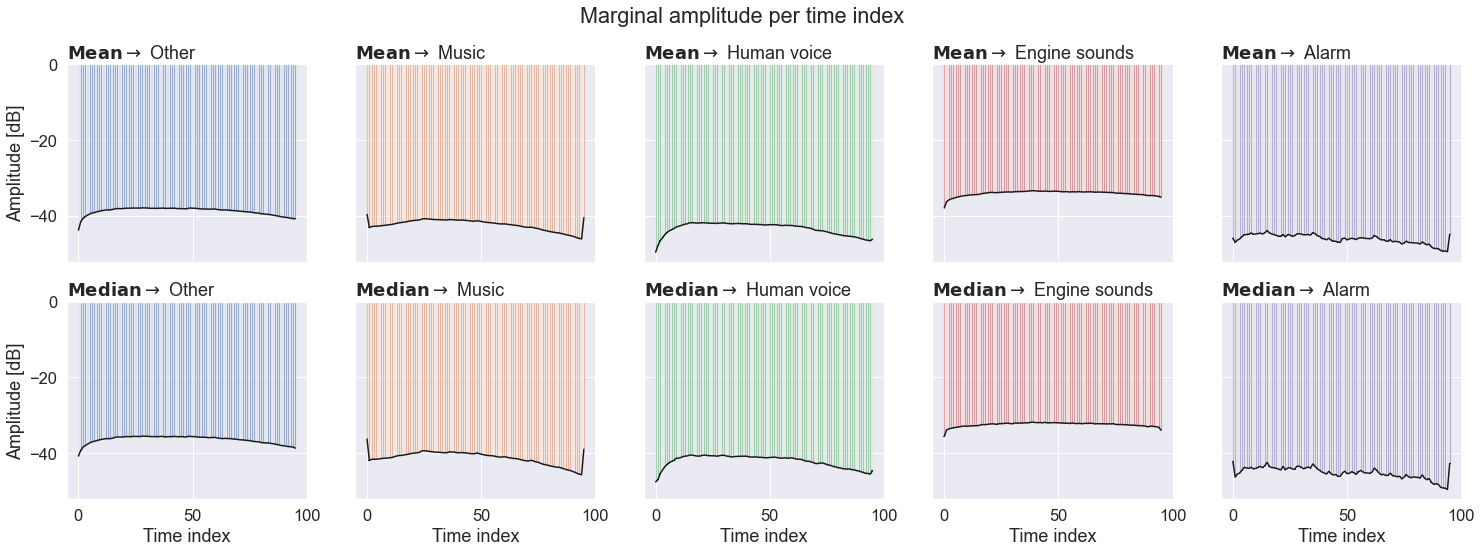

In [70]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(25, 8))

for i in range(num_classes):
    # Stack all spectrograms into 1
    Xtrain_class_v = np.vstack(Xtrain_orig[ttrain_orig == i])

    # Plot marginal mean frequency per time band
    axs[0, i].bar(np.arange(96), np.mean(Xtrain_class_v, axis=0), alpha=0.5, color=colors[i])
    axs[0, i].errorbar(np.arange(96), np.mean(Xtrain_class_v, axis=0), yerr=np.std(Xtrain_class_v, axis=0) / np.sqrt(Xtrain_class_v.shape[0]), color='k')
    axs[0, i].set_title("$\mathbf{Mean} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

    # Plot marginal median frequency per time band
    axs[1, i].bar(np.arange(96), np.median(Xtrain_class_v, axis=0), alpha=0.5, color=colors[i])
    axs[1, i].errorbar(np.arange(96), np.median(Xtrain_class_v, axis=0), yerr=np.std(Xtrain_class_v, axis=0) / np.sqrt(Xtrain_class_v.shape[0]), color='k')
    axs[1, i].set_title("$\mathbf{Median} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

    axs[1, i].set_xlabel('Time index')

axs[0, 0].set_ylabel('Amplitude [dB]')
axs[1, 0].set_ylabel('Amplitude [dB]')

fig.suptitle("Marginal amplitude per time index")
plt.show()

### Standardization

In [21]:
from typing import Optional

def standardize(X, dtype: str, mu: Optional[np.ndarray] = None, sigma: Optional[np.ndarray] = None):    
    if dtype == 'train':
        assert mu is None and sigma is None, "In training mode, the mean and standard deviation are estimated from the data."
        # Compute moments
        mu, sigma = np.mean(X, axis=0).reshape(1, X.shape[1], X.shape[2]), np.std(X, axis=0).reshape(1, X.shape[1], X.shape[2]), 
    else:
        assert mu is not None and sigma is not None, "Specify mean and standard deviation when running in evaluation mode."
    
    # Standardize
    X_ = (X - mu) / sigma
    return X_, mu, sigma

### PCA for visualization

In [22]:
# Select which dataset version we want to run with
Xtrain                  = Xtrain_downsampled
ttrain                  = ttrain_downsampled
Xval                    = Xval_orig

# Standardize
Xtrain, mu_, sigma_     = standardize(Xtrain, dtype='train')
Xval, _, _              = standardize(Xval, dtype='evaluation', mu=mu_, sigma=sigma_)

N_train = Xtrain.__len__()

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

# Transform data to PCA space
Xtrain_pca  = pca.fit_transform(Xtrain.reshape(N_train, -1), ttrain)
Xval_pca    = pca.transform(Xval.reshape(N_val, -1))

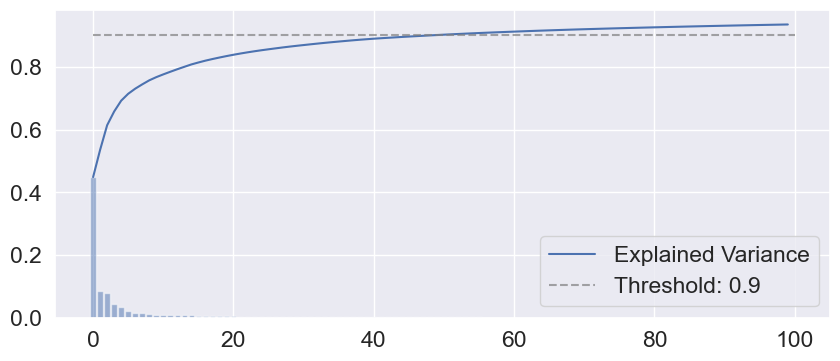

Number of components at threshold of 90%: 48


In [24]:
plt.figure(figsize=(10, 4))
plt.plot(pca.explained_variance_ratio_.cumsum(), label='Explained Variance')
plt.bar(np.arange(100), pca.explained_variance_ratio_, alpha=0.5)
plt.hlines(0.9, 0, 100, ls='--', color='gray', alpha=0.7, label='Threshold: 0.9')

plt.legend()
plt.show()

N_pca_comp = (~(pca.explained_variance_ratio_.cumsum() > 0.9)).sum()
print(f"Number of components at threshold of 90%: {N_pca_comp}")

In [25]:
# Specify new PCA features for use
Xtrain_pca  = Xtrain_pca[:, :N_pca_comp]
Xval_pca    = Xval_pca[:, :N_pca_comp]

- the first compenent contains a lot of the variance

**Question:** 
- can we choose design matrix based on visual of 2 most important components?
    - note: only two components

In [26]:
# inspired from: https://plotly.com/python/pca-visualization/

ttrain_name = [idx2label[t] for t in ttrain]
idx_samples = np.random.randint(N_train, size=int(N_train*0.08))

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    Xtrain_pca[idx_samples],
    labels=labels,
    dimensions=range(3),
    color=np.array(ttrain_name)[idx_samples]
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [27]:
pca.explained_variance_ratio_[:3]

array([0.44845113, 0.08701997, 0.07839618], dtype=float32)

In [28]:
# 3 components
total_var = pca.explained_variance_ratio_[:3].sum() * 100

fig = px.scatter_3d(
    Xtrain_pca[idx_samples], x=0, y=1, z=2, 
    color=np.array(ttrain_name)[idx_samples],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_traces(marker_size = 4)

fig.show()

- There does not seem to be any clear distinction, can we improve this?
    - LDA, ICA

## Linear Softmax classifier - Multinomial Logistic Regression

In [29]:
# Select which dataset version we want to run with

def get_dataset_version(version = 'original'):
    
    if version.lower() == 'original':
        Xtrain    = Xtrain_orig
        Xval      = Xval_orig
        ttrain    = ttrain_orig
        
    elif version.lower() == 'downsampled':
        Xtrain    = Xtrain_downsampled
        Xval      = Xval_orig
        ttrain    = ttrain_downsampled
        
    elif version.lower() == 'pca':
        if len(Xtrain_pca) == len(ttrain_orig):
            ttrain    = ttrain_orig
        else:
            ttrain    = ttrain_downsampled
            
        Xtrain    = Xtrain_pca.reshape(len(ttrain), -1, 1)
        Xval      = Xval_pca.reshape(len(tval_orig), -1, 1)

    return Xtrain, Xval, ttrain

In [36]:
Xtrain, Xval, ttrain = get_dataset_version('pca')

# Standardize
Xtrain, mu_, sigma_     = standardize(Xtrain, dtype='train')
Xval, _, _              = standardize(Xval, dtype='evaluation', mu=mu_, sigma=sigma_)

N_train = Xtrain.__len__()

In [37]:
#design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x))
design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x, x**2))
one_hot_encode  = lambda t: np.eye(num_classes)[t] 

# Create design matrices (for full data)
Phi_train       = design_matrix(Xtrain.reshape(N_train, -1))
Phi_val         = design_matrix(Xval.reshape(N_val, -1))
Phi_test        = design_matrix(Xtest.reshape(N_test, -1))

# Number of parameters
n_params        = Phi_train.shape[1]

# One-of-K encode targets
ttrain_enc      = one_hot_encode(ttrain)
tval_enc        = one_hot_encode(tval_orig)

In [75]:
# Get least squares solution
theta_hat_LS = np.linalg.solve(Phi_train.T @ Phi_train, Phi_train.T @ ttrain_enc) 

print("--- LS ESTIMATE OBTAINED ---")
print(f"Number of parameters: {theta_hat_LS.shape}")
print(f"Magnitude {np.linalg.norm(theta_hat_LS, ord=2)}")

# Get ridge solution
lambd_ = 110.
theta_hat_Ridge = np.linalg.solve(Phi_train.T @ Phi_train + lambd_ * np.eye(n_params), Phi_train.T @ ttrain_enc)

print("\n--- RIDGE ESTIMATE OBTAINED ---")
print(f"Number of parameters: {theta_hat_Ridge.shape}")
print(f"Magnitude {np.linalg.norm(theta_hat_Ridge, ord=2)}")

--- LS ESTIMATE OBTAINED ---
Number of parameters: (97, 5)
Magnitude 0.5141113940906002

--- RIDGE ESTIMATE OBTAINED ---
Number of parameters: (97, 5)
Magnitude 0.4708650545598935


In [76]:
# define softmax
softmax = lambda y: np.exp(y) / np.exp(y).sum(axis=1)[:, np.newaxis]

def predict(Phi: np.ndarray, theta: np.ndarray) -> (np.ndarray, np.ndarray):
    

    # get latent function value
    y = Phi @ theta

    # get soft probabilty scores
    prob = softmax(y)

    # get topk predictions
    pred = prob.argmax(axis=1)

    return pred, prob

# Get LS predictions 
ttrain_hat_LS, ttrain_prob_LS       = predict(Phi_train, theta_hat_LS)
tval_hat_LS, tval_prob_LS           = predict(Phi_val, theta_hat_LS)

# Get Ridge predictions 
ttrain_hat_Ridge, ttrain_prob_Ridge = predict(Phi_train, theta_hat_Ridge)
tval_hat_Ridge, tval_prob_Ridge     = predict(Phi_val, theta_hat_Ridge)

In [77]:
print("\n--- LS ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_LS == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_LS == tval_orig).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_LS):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, tval_hat_LS):.4f}")

print("\n--- RIDGE ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_Ridge == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_Ridge == tval_orig).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_Ridge):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, tval_hat_Ridge):.4f}")


--- LS ESTIMATE OBTAINED ---
Accuracy train: 0.5467
Accuracy validation: 0.5378
Balanced accuracy train: 0.5467
Balanced accuracy validation: 0.5274

--- RIDGE ESTIMATE OBTAINED ---
Accuracy train: 0.5462
Accuracy validation: 0.5393
Balanced accuracy train: 0.5462
Balanced accuracy validation: 0.5286


### Original
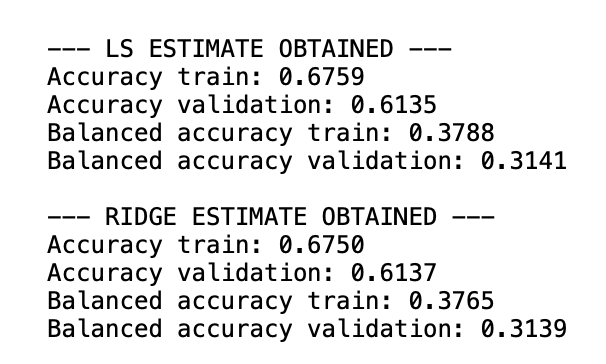

### Downsampled
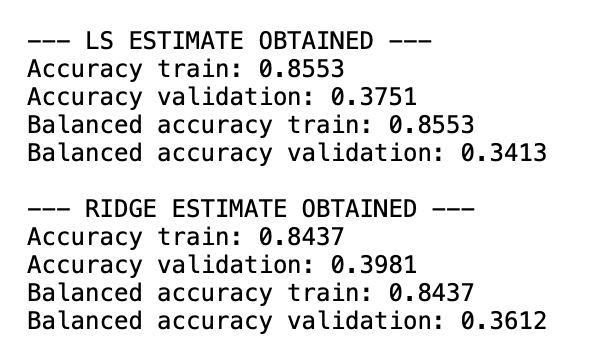

### PCA (orig)
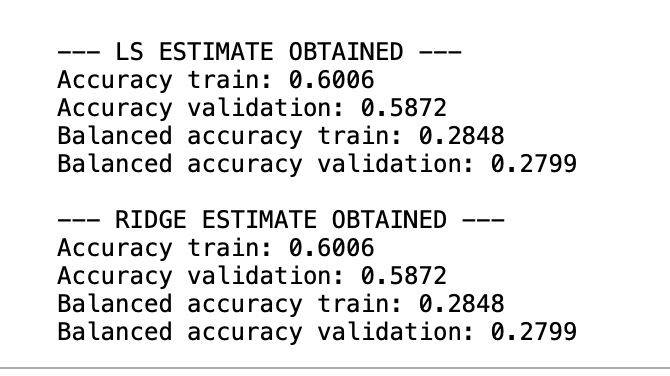

### PCA (downsampled)
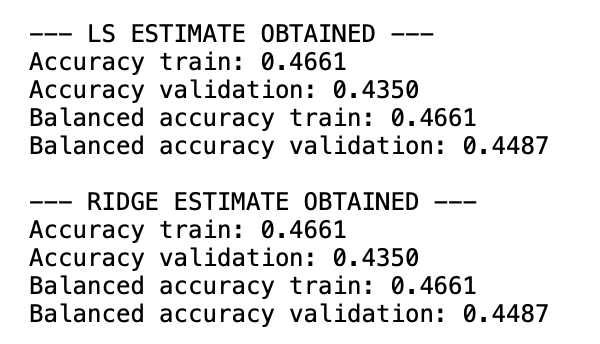

--------------------------

second order design matrix:

### Original
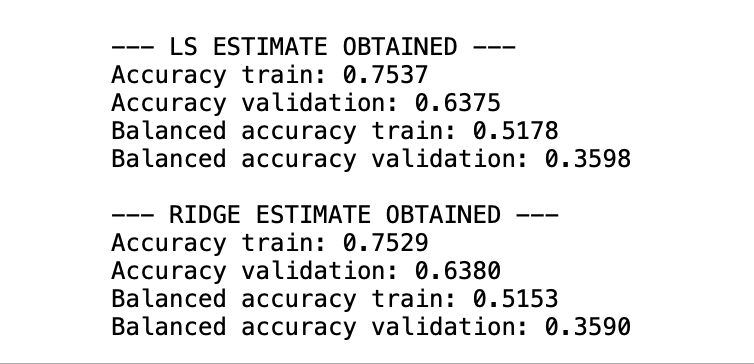

### Downsampled
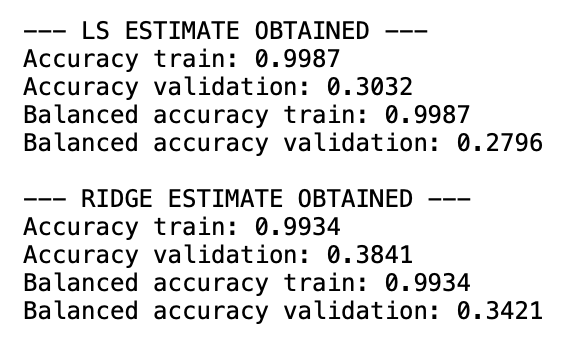

### PCA (orig)
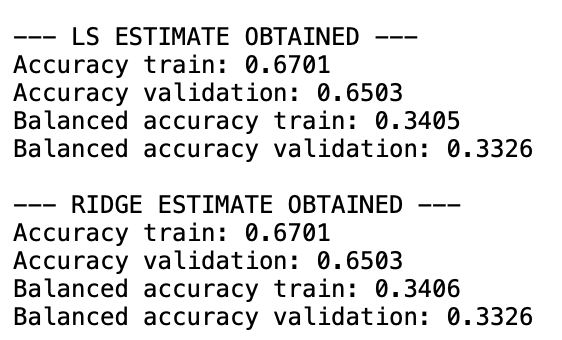

### PCA (downsampled)
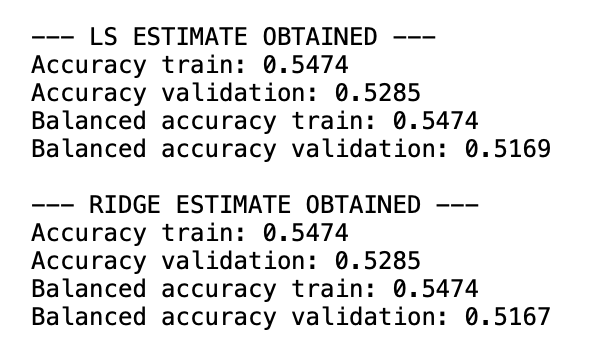

##### Optimize lambda

In [83]:
from tqdm import tqdm

accuracy = {'train': {}, 'validation': {}}
balanced_accuracy = {'train': {}, 'validation': {}}

for lambd_ in tqdm(np.linspace(0, 150, 32), desc='Optimizing regularization strength...'):
    # Get ridge solution
    theta_hat_Ridge = np.linalg.solve(Phi_train.T @ Phi_train + lambd_ * np.eye(n_params), Phi_train.T @ ttrain_enc)

    # Predict on test and validation data
    ttrain_hat_Ridge, ttrain_prob_Ridge = predict(Phi_train, theta_hat_Ridge)
    tval_hat_Ridge, tval_prob_Ridge     = predict(Phi_val, theta_hat_Ridge)

    # Store performance
    accuracy['train'][lambd_]       = (ttrain_hat_Ridge == ttrain).mean()
    accuracy['validation'][lambd_]  = (tval_hat_Ridge == tval_orig).mean()

    balanced_accuracy['train'][lambd_]       = balanced_accuracy_score(ttrain, ttrain_hat_Ridge)
    balanced_accuracy['validation'][lambd_]  = balanced_accuracy_score(tval_orig, tval_hat_Ridge)

Optimizing regularization strength...: 100%|██████████| 32/32 [00:03<00:00,  9.76it/s]


Text(0.5, 1.0, 'Balanced accuracy')

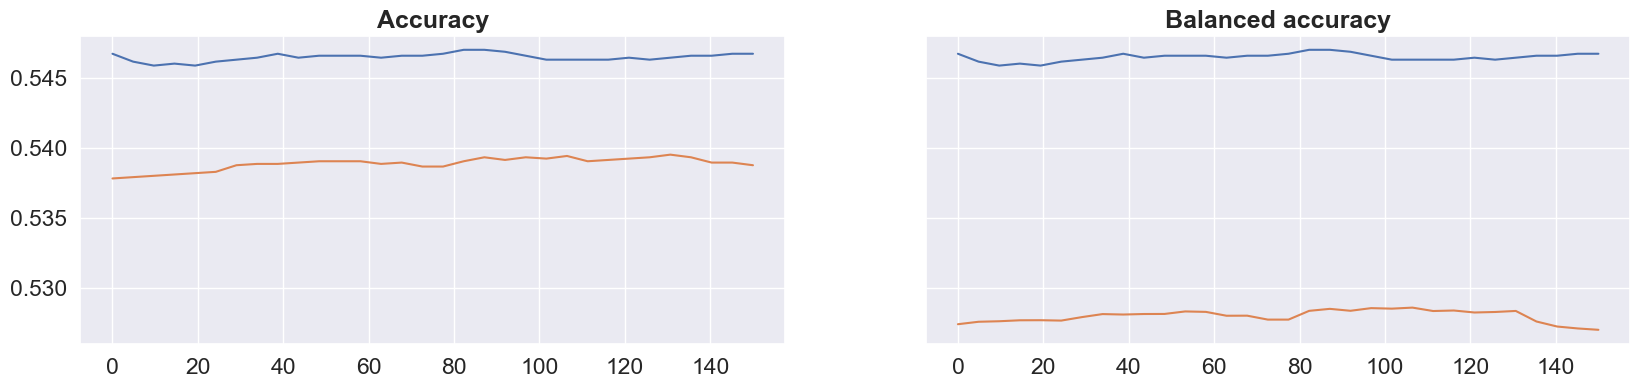

In [84]:
lamdba_grid, train_acc  = list(zip(*accuracy['train'].items()))
_, val_acc              = list(zip(*accuracy['validation'].items()))

_, train_bal_acc        = list(zip(*balanced_accuracy['train'].items()))
_, val_bal_acc          = list(zip(*balanced_accuracy['validation'].items()))

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 4))

axs[0].plot(lamdba_grid, train_acc, color='C0', label='Training')
axs[0].plot(lamdba_grid, val_acc, color='C1', label='Validation')
axs[0].set_title('Accuracy', weight='bold')

axs[1].plot(lamdba_grid, train_bal_acc, color='C0', label='Training')
axs[1].plot(lamdba_grid, val_bal_acc, color='C1', label='Validation')
axs[1].set_title('Balanced accuracy', weight='bold')

### Evaluation 

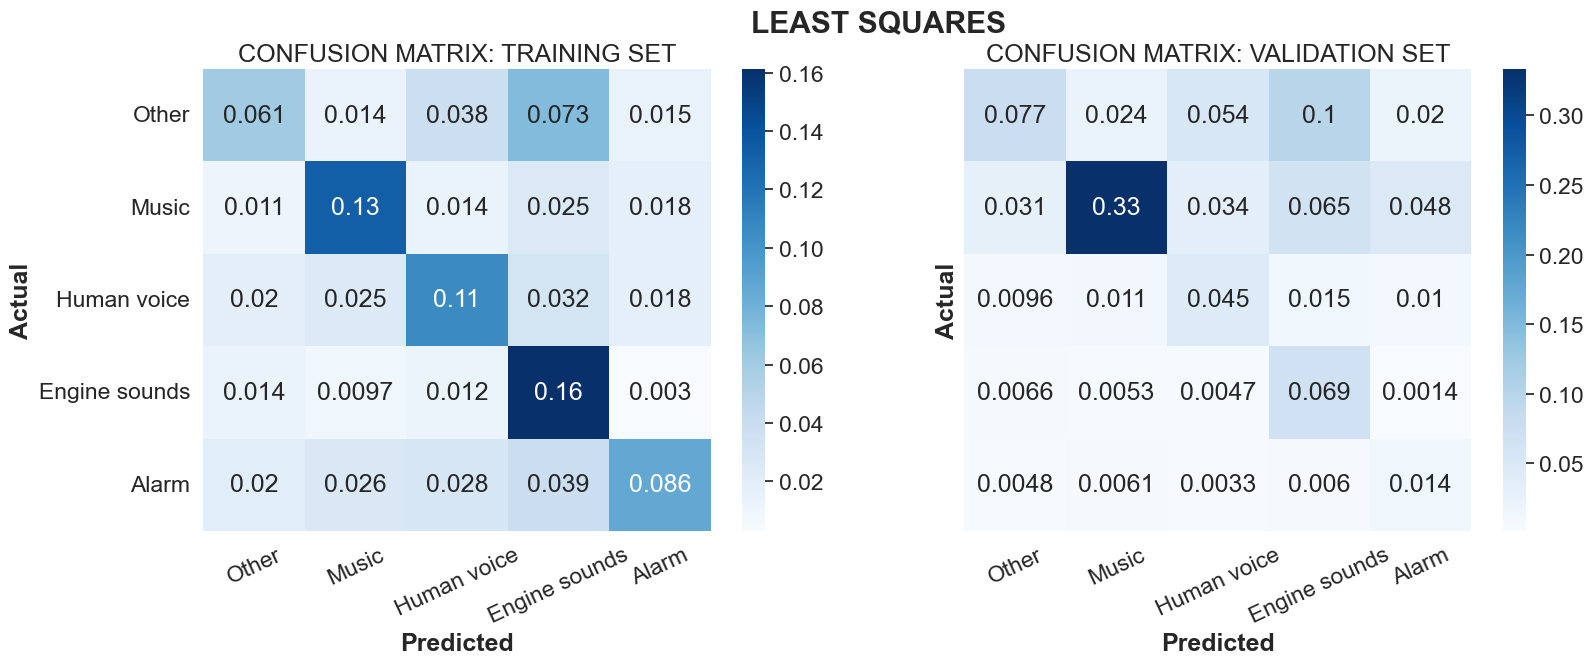

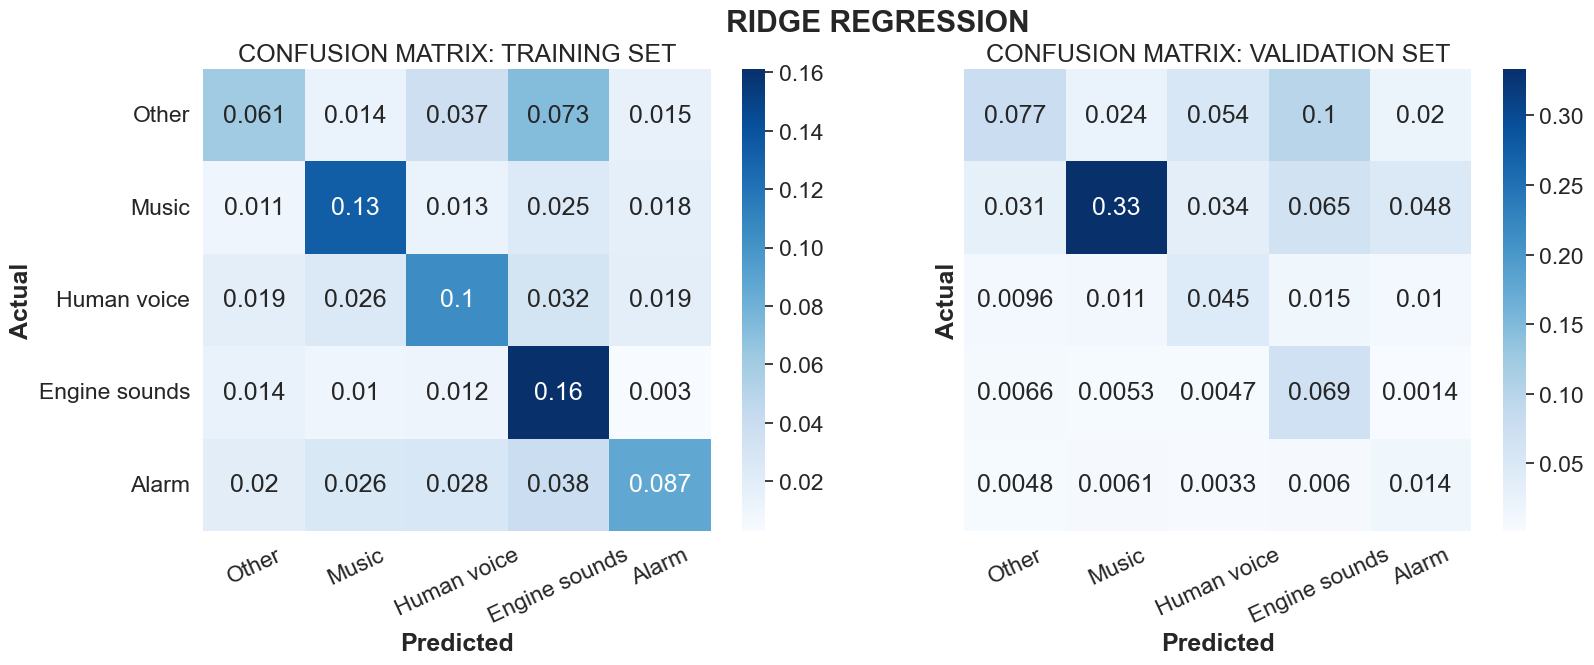

In [87]:
# Compute confusion matrices for least squares predictions
cm_train_LS = confusion_matrix(ttrain, ttrain_hat_LS, normalize='all')
cm_val_LS   = confusion_matrix(tval_orig, tval_hat_LS, normalize='all')

# Compute confusion matrices for ridge predictions
cm_train_Ridge = confusion_matrix(ttrain, ttrain_hat_Ridge, normalize='all')
cm_val_Ridge   = confusion_matrix(tval_orig, tval_hat_Ridge, normalize='all')


for reg_type in ['least squares', 'ridge regression']:
    
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18, 6))
    for i, (dtype, cm_) in enumerate({
        'training set': cm_train_LS if reg_type == 'least squares' else cm_train_Ridge, 
        'validation set': cm_val_LS if reg_type == 'least_squares' else cm_val_Ridge,
    }.items()):

        # Plot confusion matrix as heatmap
        sns.heatmap(cm_, annot=True, cmap='Blues', ax=axs[i])

        # Set ticks
        ticks = list(zip(*[(i + 0.5, name_) for i, name_ in idx2label.items()]))
        axs[i].set_xticks(ticks[0], ticks[1], rotation=25)
        axs[i].set_yticks(ticks[0], ticks[1], rotation=0)

        # Set labels and title
        axs[i].set_ylabel('Actual', weight='bold')
        axs[i].set_xlabel('Predicted', weight='bold')
        axs[i].set_title(f"Confusion matrix: {dtype}".upper())

    fig.suptitle(f'{reg_type}'.upper(), weight='bold')
    plt.show()

### Decision theory: utility functions

In [88]:
def visualize_utility(ax, U, labels=None):
    
    num_classes = len(U)
    
    ax.imshow(U, cmap=plt.cm.Greys_r, alpha=0.5)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    
    if labels:
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
    
    ax.grid(False)
    
    for (j,i), val in np.ndenumerate(U):
        ax.text(i,j, val, ha='center', va='center', fontsize=16)
    ax.set_title('Utility matrix', fontweight='bold')
    
def visualize_confusion_matrix(fig, ax, cm_, reg_type, dtype):
    # Plot confusion matrix as heatmap
    sns.heatmap(cm_, annot=True, cmap='Blues', ax=ax)

    # Set ticks
    ticks = list(zip(*[(i + 0.5, name_) for i, name_ in idx2label.items()]))
    ax.set_xticks(ticks[0], ticks[1], rotation=25)
    ax.set_yticks(ticks[0], ticks[1], rotation=0)

    # Set labels and title
    ax.set_ylabel('Actual', weight='bold')
    ax.set_xlabel('Predicted', weight='bold')
    ax.set_title(f"Confusion matrix: {dtype}".upper())
    fig.suptitle(f'{reg_type}'.upper(), weight='bold')
    return fig, ax

No change:

In [89]:
U = np.identity(num_classes)

# computing the expected utility for each class
EU_train = ttrain_prob_Ridge@U
EU_val = tval_prob_Ridge@U

# not one hot
U_ttrain = EU_train.argmax(axis=1)
U_tval = EU_val.argmax(axis=1)


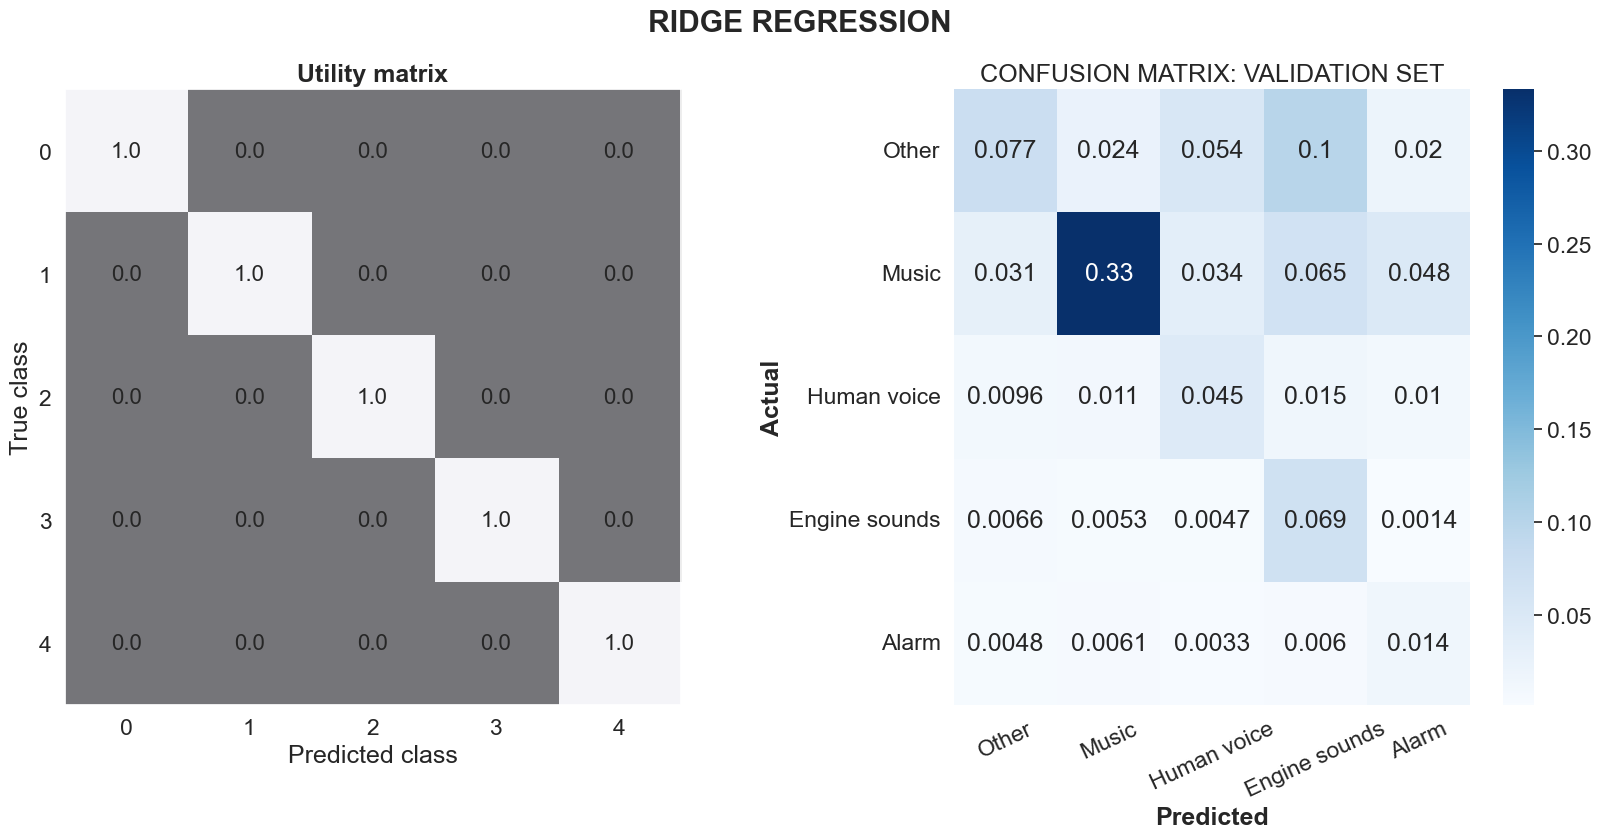

In [90]:
# plot everything
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# utility matrix
visualize_utility(axes[0], U)

# plotting the new confusion matrix
cm_val_Ridge   = confusion_matrix(tval_orig, U_tval, normalize='all')

fig, axes[1] = visualize_confusion_matrix(fig, axes[1], cm_val_Ridge, 'ridge regression', 'validation set')

#fig.tight_layout()
#fig.subplots_adjust(hspace=10)
fig.subplots_adjust(wspace=0.4)
plt.show()


**Comments:**
- We see that 'Other' and 'Music' are often confused with the other categories.


**Thoughts on utility:**
- In general we want to predict 'Engine sounds' and 'Alarm' rather than the other categories
    - And since we do not want to remove these noises:
        - Not expect to remove noise from 'Other', so it can remain unadjusted
        - Expect to remove noise from 'Music', so rather predict 'Engine sounds and 'Alarm'
- Traffic noise is important
- 

In [91]:
U = np.identity(num_classes)
#U[1,1] = 0.5
U[3, :] = [0, -1, 0, 1, 0]
U[4, :] = [0, -1, 0, 0, 1]

# computing the expected utility for each class
EU_train = ttrain_prob_Ridge@U
EU_val = tval_prob_Ridge@U

# not one hot
U_ttrain = EU_train.argmax(axis=1)
U_tval = EU_val.argmax(axis=1)


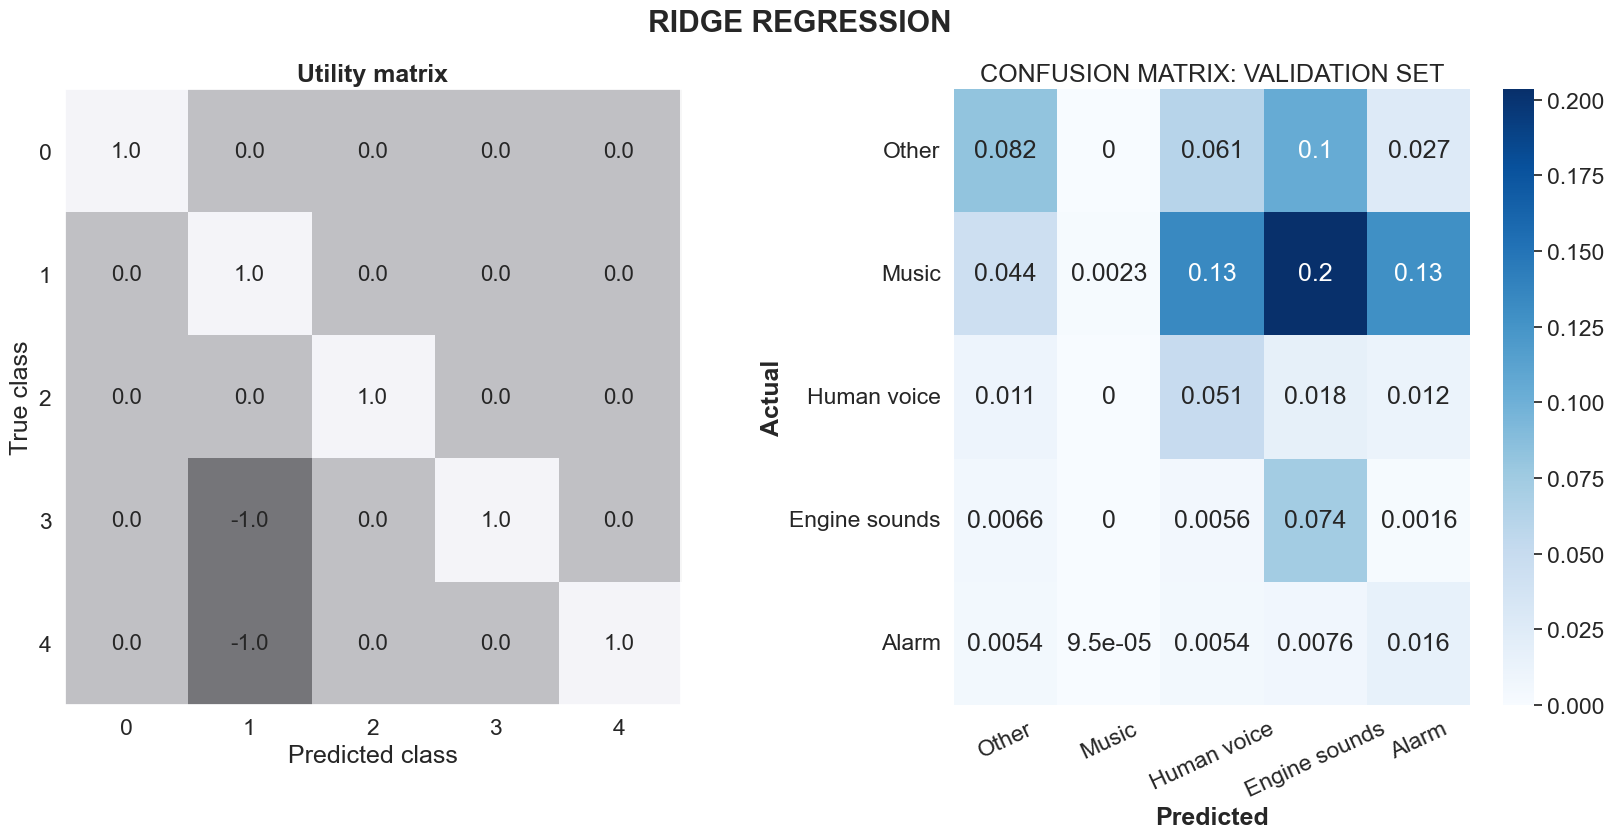

In [92]:
# plot everything
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# utility matrix
visualize_utility(axes[0], U)

# plotting the new confusion matrix
cm_val_Ridge   = confusion_matrix(tval_orig, U_tval, normalize='all')

fig, axes[1] = visualize_confusion_matrix(fig, axes[1], cm_val_Ridge, 'ridge regression', 'validation set')

#fig.tight_layout()
#fig.subplots_adjust(hspace=10)
fig.subplots_adjust(wspace=0.4)
plt.show()


In [93]:
print("\n--- ORIGINAL RIDGE ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_Ridge == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_Ridge == tval_orig).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_Ridge):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, tval_hat_Ridge):.4f}")

print("\n--- NEW RIDGE ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(U_ttrain == ttrain).mean():.4f}")
print(f"Accuracy validation: {(U_tval == tval_orig).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, U_ttrain):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, U_tval):.4f}")


--- ORIGINAL RIDGE ESTIMATE OBTAINED ---
Accuracy train: 0.5467
Accuracy validation: 0.5388
Balanced accuracy train: 0.5467
Balanced accuracy validation: 0.5270

--- NEW RIDGE ESTIMATE OBTAINED ---
Accuracy train: 0.4488
Accuracy validation: 0.2250
Balanced accuracy train: 0.4488
Balanced accuracy validation: 0.4338


**Question:**
- can we handle class imbalance where? e.g. multiply identity with the proportions?

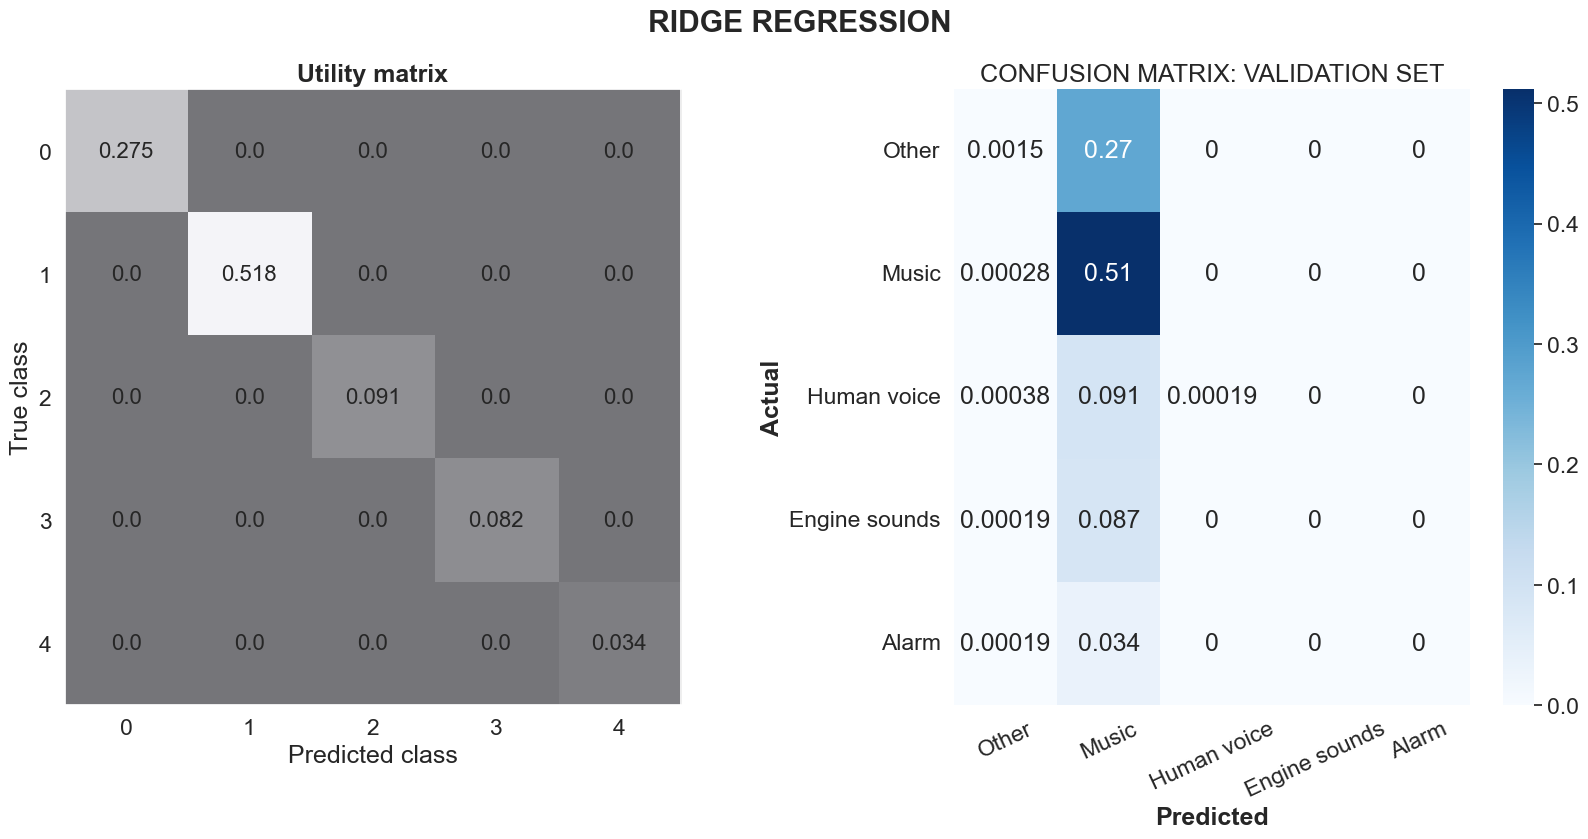


--- ORIGINAL RIDGE ESTIMATE OBTAINED ---
Accuracy train: 0.5467
Accuracy validation: 0.5388
Balanced accuracy train: 0.5467
Balanced accuracy validation: 0.5270

--- NEW RIDGE ESTIMATE OBTAINED ---
Accuracy train: 0.2013
Accuracy validation: 0.5134
Balanced accuracy train: 0.2013
Balanced accuracy validation: 0.2014


In [94]:
proportions = [round(label_freqs['train'][v], 3) for v in idx2label.values()]

U = np.identity(num_classes) * proportions
# computing the expected utility for each class
EU_train = ttrain_prob_Ridge@U
EU_val = tval_prob_Ridge@U

# not one hot
U_ttrain = EU_train.argmax(axis=1)
U_tval = EU_val.argmax(axis=1)

    
# plot everything
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# utility matrix
visualize_utility(axes[0], U)

# plotting the new confusion matrix
cm_val_Ridge   = confusion_matrix(tval_orig, U_tval, normalize='all')

fig, axes[1] = visualize_confusion_matrix(fig, axes[1], cm_val_Ridge, 'ridge regression', 'validation set')

#fig.tight_layout()
#fig.subplots_adjust(hspace=10)
fig.subplots_adjust(wspace=0.4)
plt.show()

print("\n--- ORIGINAL RIDGE ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_Ridge == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_Ridge == tval_orig).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_Ridge):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, tval_hat_Ridge):.4f}")

print("\n--- NEW RIDGE ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(U_ttrain == ttrain).mean():.4f}")
print(f"Accuracy validation: {(U_tval == tval_orig).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, U_ttrain):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, U_tval):.4f}")


- did not work

## Autoencoder

In [95]:
from collections import OrderedDict

import torch
import torch.nn as nn

In [49]:
import torch.nn as nn

def get_activation(activation: str):
    if activation == 'ReLU':
        return nn.ReLU()
    else:
        raise NotImplementedError

class ConvEncoderBlock(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, kernel_size: int, stride: int, padding: int = 0, activation='ReLU'):
        super(ConvEncoderBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            channels_in,
            channels_out,
            kernel_size,
            stride,
            padding,
        )
        self.bn1    = nn.BatchNorm2d(channels_out)
        self.act1   = get_activation(activation)
        self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.pool1(out)
        return out

class TransposeConvDecoderBlock(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, kernel_size: int, stride: int, padding: int = 0, activation='ReLU'):
        super(TransposeConvDecoderBlock, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(
            channels_in,
            channels_out,
            kernel_size,
            stride,
            padding,
        )

        self.conv1 = nn.ConvTranspose2d(
            channels_in, 
            channels_out, 
            kernel_size=2, 
            stride=2
        )
        self.bn1    = nn.BatchNorm2d(channels_out)
        self.act1   = get_activation(activation) 
    
    def forward(self, z):
        out = self.conv1(z)
        out = self.bn1(out)
        out = self.act1(out)
        return out
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # setup parts
        self.encoder = nn.Sequential(OrderedDict([
            ('block1', ConvEncoderBlock(1, 256, kernel_size=3, stride=1, padding=1)),
            ('block2', ConvEncoderBlock(256, 128, kernel_size=3, stride=1, padding=1)),
            ('block3', ConvEncoderBlock(128, 64, kernel_size=3, stride=1, padding=1)),
            ('block4', ConvEncoderBlock(64, 32, kernel_size=3, stride=1, padding=1)),
        ]))
        self.encoder_fc = nn.Linear(in_features=32*6*2, out_features=32)

        self.decoder_fc = nn.Linear(in_features=32, out_features=32*6*2)
        self.decoder = nn.Sequential(OrderedDict([
            ('block1', TransposeConvDecoderBlock(32, 64, kernel_size=2, stride=2)),
            ('block2', TransposeConvDecoderBlock(64, 128, kernel_size=2, stride=2)),
            ('block3', TransposeConvDecoderBlock(128, 256, kernel_size=2, stride=2)),
            ('block4', TransposeConvDecoderBlock(256, 1, kernel_size=2, stride=2)),
        ]))

    def forward(self, x):
        # Encode input
        x_ = self.encoder(x)
        z = self.encoder_fc(x_.view(x.shape[0], -1))

        # Decode encoded input
        z_ = self.decoder_fc(z).view(x_.shape)
        x_recon = self.decoder(z_)
    
        return {'x_recon': x_recon, 'z': z}

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() 
                 #else 'mps' if torch.backends.mps.is_available() 
                 else 'cpu')

AE = ConvAutoencoder().to(device)
print(AE)

ConvAutoencoder(
  (encoder): Sequential(
    (block1): ConvEncoderBlock(
      (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): ConvEncoderBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): ConvEncoderBlock(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

In [33]:
print(f"Encoder parameters: \t\t{sum(param_.numel() for param_ in AE.encoder.parameters()) + sum(param_.numel() for param_ in AE.encoder_fc.parameters())}")
print(f"Decoder parameters: \t\t{sum(param_.numel() for param_ in AE.decoder.parameters())}")
print(f"Total number of parameters: \t{sum(param_.numel() for param_ in AE.parameters())}")

Encoder parameters: 		403136
Decoder parameters: 		174403
Total number of parameters: 	590211


In [34]:
# Create a dummy batch
x = torch.tensor(Xtrain[:32, :, :]).unsqueeze(1).to(device)
# Get reconstructions
output = AE(x)

print(output['x_recon'].shape)
print(output['z'].shape)

torch.Size([32, 1, 32, 96])
torch.Size([32, 1, 32, 96])
torch.Size([32, 32])


In [36]:
z1 = AE.encoder.block1(x)
z2 = AE.encoder.block2(z1)
z3 = AE.encoder.block3(z2)
z4 = AE.encoder.block4(z3)
z5 = AE.encoder_fc(z4.view(x.shape[0], -1))

print("Encoder shapes:")
print(z1.shape)
print(z2.shape)
print(z3.shape)
print(z4.shape)
print(z5.shape)

x1 = AE.decoder_fc(z5).view(z4.shape)
x2 = AE.decoder.block1(x1)
x3 = AE.decoder.block2(x2)
x4 = AE.decoder.block3(x3)
x5 = AE.decoder.block4(x4)

print("\nDecoder shapes:")
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

Encoder shapes:
torch.Size([32, 256, 16, 48])
torch.Size([32, 128, 8, 24])
torch.Size([32, 64, 4, 12])
torch.Size([32, 32, 2, 6])
torch.Size([32, 32])

Decoder shapes:
torch.Size([32, 32, 2, 6])
torch.Size([32, 64, 4, 12])
torch.Size([32, 128, 8, 24])
torch.Size([32, 256, 16, 48])
torch.Size([32, 1, 32, 96])


In [37]:
from torch.utils.data import Dataset

class OticonAudioExplorers(Dataset):
    
    def __init__(self, data, labels):
        self.data      = data
        self.labels    = labels
                
        # Define number of classes
        self.n_classes = np.unique(self.labels).__len__()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return {
            "data":  self.data[item, :], 
            "label": self.labels[item], 
        }

In [67]:
def get_loaders(data_path: str = '../data', 
                do_downsample: bool = False, 
                batch_size: int = 32,
                shuffle: bool = True,
                # num_workers: int = 1,
                val_size: float = 0.2):

    data_path = Path(data_path)
    
    # Load npy-files
    data   = np.load(data_path / 'raw/npy/training.npy')
    labels = np.load(data_path / 'raw/npy/training_labels.npy')

    # Get indexes
    train_idxs  = np.random.choice(np.arange(data.__len__()), size=int(data.__len__() * (1-val_size)), replace=False)
    val_idxs    = np.setdiff1d(np.arange(data.__len__()), train_idxs)

    assert data.__len__() == train_idxs.__len__() + val_idxs.__len__()

    # Put into get loaders func.
    # Split training set
    Xtrain, Xval = data[train_idxs, :, :], data[val_idxs, :, :]
    ttrain, tval = labels[train_idxs],     labels[val_idxs]

    if do_downsample:
        Xtrain, ttrain = downsample(Xtrain, ttrain)
        
    # Creating datasets
    train_dataset = OticonAudioExplorers(Xtrain, ttrain)
    val_dataset   = OticonAudioExplorers(Xval, tval)
    
    # Initializing loaders
    loaders = [
        torch.utils.data.DataLoader(
            dataset_,
            batch_size=batch_size,
            shuffle=shuffle)
            #num_workers=num_workers)
        for dataset_ in [train_dataset, val_dataset]
    ]
            
    return {'Train': loaders[0], 'Validation': loaders[1]}

# Example of loader with batch size 1
loaders = get_loaders(batch_size = 1)
next(iter(loaders['Train']))

{'data': tensor([[[-19.6912,  -8.8602,  -9.2986,  ..., -20.2685, -20.6808, -25.5366],
          [-14.1634,   0.0000,  -4.5615,  ..., -20.9439, -21.6888, -27.4645],
          [-16.1211,  -5.2711,  -7.5277,  ..., -22.7450, -23.0078, -24.2426],
          ...,
          [-64.4427, -62.7328, -69.0232,  ..., -80.0000, -80.0000, -63.7799],
          [-70.1407, -74.6657, -80.0000,  ..., -80.0000, -80.0000, -64.3619],
          [-73.7355, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -64.8976]]]),
 'label': tensor([1], dtype=torch.int32)}

In [39]:
def get_model(device, lr = 1e-3):
    
    # init model
    AE = ConvAutoencoder().to(device)
    
    # create an optimizer object
    optimizer = torch.optim.Adam(AE.parameters(), lr=lr)

    # mean-squared error loss
    criterion = nn.MSELoss()
    
    return AE, optimizer, criterion

In [65]:
def train(model_name: str, 
          experiment_name: str,
          epochs: int = 100, 
          checkpoint_every_epoch: int = 5,
          lr: float = 1e-3,
          batch_size: int = 128,
          val_pct: float = 0.2,
          seed: int = 42, 
          data_path: str = '../data',
          save_path: str = '../models',
          do_downsample: bool = False):
    
    # set seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    device = torch.device('cuda' if torch.cuda.is_available() 
                 #else 'mps' if torch.backends.mps.is_available() 
                 else 'cpu')
    
    loaders = get_loaders(data_path = data_path, 
                        do_downsample = do_downsample, 
                        batch_size = batch_size,
                        shuffle = True,
                        # num_workers: int = 1,
                        val_size = val_pct)
    
    model, optimizer, criterion = get_model(device, lr = 1e-3)
    
    current_best_loss = np.inf
    
    with trange(epochs) as t:
        for epoch in t:
            
            running_loss_train, running_loss_val = 0, 0
            
            model.train()
            
            for batch in tqdm(iter(loaders['Train'])):
                
                optimizer.zero_grad()
                
                # get x from loader
                x = torch.tensor(batch['data']).unsqueeze(1).to(device)
                
                # send x through model
                x_recon = model(x)['x_recon']
                
                train_loss = criterion(x_recon, x)
                
                # compute accumulated gradients
                train_loss.backward()

                # perform parameter update based on current gradients
                optimizer.step()

                # add the mini-batch training loss to epoch loss
                running_loss_train += train_loss.item()
                
            # compute the epoch training loss
            running_loss_train = running_loss_train / len(loaders['Train'])

            # display the epoch training loss
            print("epoch : {}/{}, training loss = {:.6f}".format(epoch + 1, epochs, running_loss_train))
            
            model.eval()
            with torch.no_grad():
                for batch in tqdm(iter(loaders['Validation'])):
                    
                    # get x from loader
                    x = torch.tensor(batch['data']).unsqueeze(1).to(device)
                    
                    # send x through model
                    x_recon = model(x)['x_recon']

                    val_loss = criterion(x_recon, x)

                    # add the mini-batch training loss to epoch loss
                    running_loss_val += val_loss.item()

                # compute the epoch validation loss
                running_loss_val = running_loss_val / len(loaders['Validation'])

                # display the epoch validation loss
                print("epoch : {}/{}, validation loss = {:.6f}".format(epoch + 1, epochs, running_loss_val))
                
            if running_loss_val < current_best_loss and epoch % checkpoint_every_epoch == 0:
                current_best_loss = running_loss_val
                
                checkpoint = {
                    "experiment_name": experiment_name,
                    "seed": seed,
                    "model": {
                        'name': model_name,
                    },
                    "training_parameters": {
                        "save_path": save_path,
                        "lr": lr,
                        "optimizer": optimizer,
                        "epochs": epochs,
                        "batch_size": batch_size,
                        "device": device,
                    },
                    "best_epoch": epoch + 1,
                    "state_dict": model.state_dict(),
                }
                os.makedirs(f"{save_path}/{experiment_name}", exist_ok=True)
                torch.save(checkpoint, f"{save_path}/{experiment_name}/best.ckpt")

train(model_name              = 'testing', 
      experiment_name         = 'testing',
      lr                      = 1e-3,
      epochs                  = 5, 
      checkpoint_every_epoch  = 1,
      batch_size              = 32,
      do_downsample           = True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

/var/folders/xq/4pwj6w6x1rx8l3hmyx653y200000gn/T/ipykernel_58878/2790712414.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(batch['data']).unsqueeze(1).to(device)


epoch : 1/5, training loss = 2093.472565


  0%|          | 0/83 [00:00<?, ?it/s]

/var/folders/xq/4pwj6w6x1rx8l3hmyx653y200000gn/T/ipykernel_58878/2790712414.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(batch['data']).unsqueeze(1).to(device)


epoch : 1/5, validation loss = 2114.898087


  0%|          | 0/56 [00:00<?, ?it/s]

epoch : 2/5, training loss = 2091.654731


  0%|          | 0/83 [00:00<?, ?it/s]

epoch : 2/5, validation loss = 2114.164679


  0%|          | 0/56 [00:00<?, ?it/s]

epoch : 3/5, training loss = 2090.320980


  0%|          | 0/83 [00:00<?, ?it/s]

epoch : 3/5, validation loss = 2114.341844


  0%|          | 0/56 [00:00<?, ?it/s]

epoch : 4/5, training loss = 2090.287630


  0%|          | 0/83 [00:00<?, ?it/s]

epoch : 4/5, validation loss = 2115.195376


  0%|          | 0/56 [00:00<?, ?it/s]

epoch : 5/5, training loss = 2092.273352


  0%|          | 0/83 [00:00<?, ?it/s]

epoch : 5/5, validation loss = 2114.590479
